### Import libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import joblib

import os

### Helper functions

In [2]:
def plot_on_lift_or_not_on_lift(df, plot_title='On lift vs. not on lift'):
    """
    Plot altitude over time, colored by 'on_lift' status.
    Will not plot if 'Timestamp' column is in wrong format.

    Parameters:
        df (DataFrame): DataFrame containing 'Timestamp' and 'Alt(m)' columns.
        plot_title (str, optional): Title of the plot (default is 'On lift vs. not on lift').

    This function creates a scatter plot to visualize the altitude changes over time.
    Altitude data is color-coded based on the 'on_lift' status: 'On the lift' (in red) and 'Not on the lift' (in blue).
    Customize line thickness and marker size as needed.
    """

    # Check if 'Timestamp' column exists and is in datetime format
    if 'Timestamp' in df.columns and pd.api.types.is_datetime64_any_dtype(df['Timestamp']):
        # Plot for Altitude over Time, colored by 'on_lift' status
        plt.figure(figsize=(15, 5))

        # Plot points where 'on_lift' is 1 with one color
        plt.scatter(df.loc[df['on_lift'] == 1, 'Timestamp'],
                    df.loc[df['on_lift'] == 1, 'Alt(m)'],
                    c='red',
                    label='On the lift',
                    marker='o',
                    linewidths=3,
                    s=2
                   )

        # Plot points where 'on_lift' is 0 with another color
        plt.scatter(df.loc[df['on_lift'] == 0, 'Timestamp'],
                    df.loc[df['on_lift'] == 0, 'Alt(m)'],
                    c='blue',
                    label='Not on the lift',
                    marker='o',
                    linewidths=3,
                    s=2)

        plt.title(plot_title)
        plt.xlabel('Timestamp')
        plt.ylabel('Altitude (m)')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("Warning: DataFrame's 'Timestamp' column is not in datetime format and must be converted first.")


In [3]:
def plot_lift_rides(df, plot_title='Tracked data'):

    # Check if 'Timestamp' column exists and is in datetime format
    if 'Timestamp' in df.columns and pd.api.types.is_datetime64_any_dtype(df['Timestamp']):
        # Plot for Altitude over Time, colored by 'on_lift' status
        plt.figure(figsize=(15, 5))

        # Plot points where 'on_lift' is 1 with one color
        plt.scatter(df.loc[df['on_lift'] == 1, 'Timestamp'],
                    df.loc[df['on_lift'] == 1, 'Alt(m)'],
                    c='blue',
                    marker='o',
                    linewidths=3,
                    s=2
                   )

        # Plot points where 'on_lift' is 0 with another color
        plt.scatter(df.loc[df['on_lift'] == 0, 'Timestamp'],
                    df.loc[df['on_lift'] == 0, 'Alt(m)'],
                    c='blue',
                    marker='o',
                    linewidths=3,
                    s=2)

        plt.title(plot_title)
        plt.xlabel('Timestamp')
        plt.ylabel('Altitude (m)')
        # plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("Warning: DataFrame's 'Timestamp' column is not in datetime format and must be converted first.")


In [4]:
def check_predictions(df, plot_title='Predictions'):
    # Check if 'Timestamp' column exists and is in datetime format
    if 'Timestamp' in df.columns and pd.api.types.is_datetime64_any_dtype(df['Timestamp']):
        # Create a scatter plot for Altitude over Time, colored by 'predicted' class
        fig = px.scatter(df, x='Timestamp', y='Alt(m)', color='predicted',
                         labels={'Alt(m)': 'Altitude (m)'},
                         title=plot_title,
                         color_discrete_map={0: 'blue', 1: 'red'})

        fig.update_traces(marker=dict(size=8),
                          selector=dict(mode='markers'))

        # Customize the legend
        fig.update_layout(
            legend_title_text='Status',
            width=1000,
            height=900
        )

        fig.for_each_trace(lambda trace: trace.update(name='Not on the lift' if trace.name == 0 else 'On the lift'))

        # Show the plot
        fig.show()
    else:
        print("Warning: DataFrame's 'Timestamp' column is not in datetime format and must be converted first.")

### Import data for training

In [12]:
# file locations in directory - please update regarding your environment !!!
df_57_file='/content/df_57_relabeled.csv'
df_95_file='/content/df_95_labeled_on_lift.csv'
df_135_file='/content/df_135_relabeled.csv'
df_166_file='/content/df_166_relabeled.csv'
df_206_file='/content/df_206_relabeled.csv'
df_290_file='/content/df_290_relabeled.csv'
df_310_file='/content/df_310_labeled_on_lift_v4.csv'

#kate's data
df_Andermatt_Gutsch_file='/content/df_Andermatt_Gutsch_relabeled.csv'
df_Natschen_46_file='/content/df_Natschen_46_relabeled.csv'



In [13]:
# create dataframes from csv files
df_57=pd.read_csv(df_57_file)
df_95=pd.read_csv(df_95_file)
df_135=pd.read_csv(df_135_file)
df_166=pd.read_csv(df_166_file)
df_206=pd.read_csv(df_206_file)
df_290=pd.read_csv(df_290_file)
df_310=pd.read_csv(df_310_file)

#kate's data we use for model v0.4 with no passages where lift is going down
df_Andermatt_Gutsch=pd.read_csv(df_Andermatt_Gutsch_file)
df_Natschen_46=pd.read_csv(df_Natschen_46_file)



In [14]:
# list with all dataframes for training
df_lst_train=[
        df_57,
        df_135,
        df_166,
        df_206,
        df_290,
        df_Andermatt_Gutsch,
        df_Natschen_46
        ]

# list with all dataframes for test
df_lst_test=[
    df_95,
    df_310
]

In [15]:
# Convert to datetime format
df_57['Timestamp'] = pd.to_datetime(df_57['Timestamp'], unit='ns')
df_95['Timestamp'] = pd.to_datetime(df_95['Timestamp'], unit='ns')
df_135['Timestamp'] = pd.to_datetime(df_135['Timestamp'], unit='ns')
df_166['Timestamp'] = pd.to_datetime(df_166['Timestamp'], unit='ns')
df_206['Timestamp'] = pd.to_datetime(df_206['Timestamp'], unit='ns')
df_290['Timestamp'] = pd.to_datetime(df_290['Timestamp'], unit='ns')
df_310['Timestamp'] = pd.to_datetime(df_310['Timestamp'], unit='ns')
df_Andermatt_Gutsch['Timestamp'] = pd.to_datetime(df_Andermatt_Gutsch['Timestamp'], unit='ns')
df_Natschen_46['Timestamp'] = pd.to_datetime(df_Natschen_46['Timestamp'], unit='ns')


In [10]:
df_Andermatt_Gutsch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11121 entries, 0 to 11120
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Timestamp                 11121 non-null  datetime64[ns]
 1   gyroZ(rad/s)              11121 non-null  float64       
 2   gyroY(rad/s)              11121 non-null  float64       
 3   gyroX(rad/s)              11121 non-null  float64       
 4   accelUserZ(g)             11121 non-null  float64       
 5   accelUserY(g)             11121 non-null  float64       
 6   accelUserX(g)             11121 non-null  float64       
 7   RelativeAltitude(meters)  11121 non-null  float64       
 8   Pressure(kilopascals)     11121 non-null  float64       
 9   accelZ(g)                 11121 non-null  float64       
 10  accelY(g)                 11121 non-null  float64       
 11  accelX(g)                 11121 non-null  float64       
 12  VerticalAccuracy(m

1


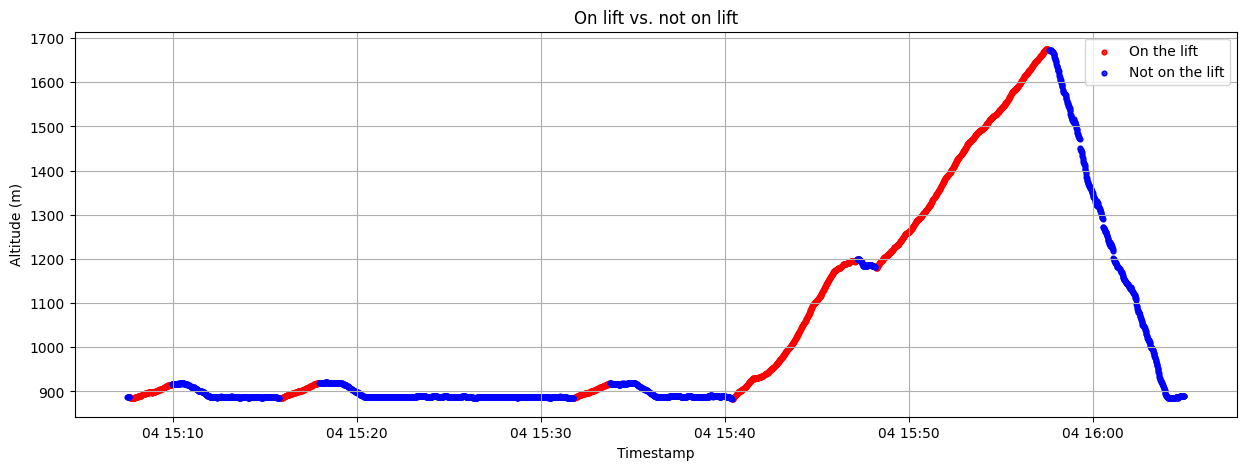

2


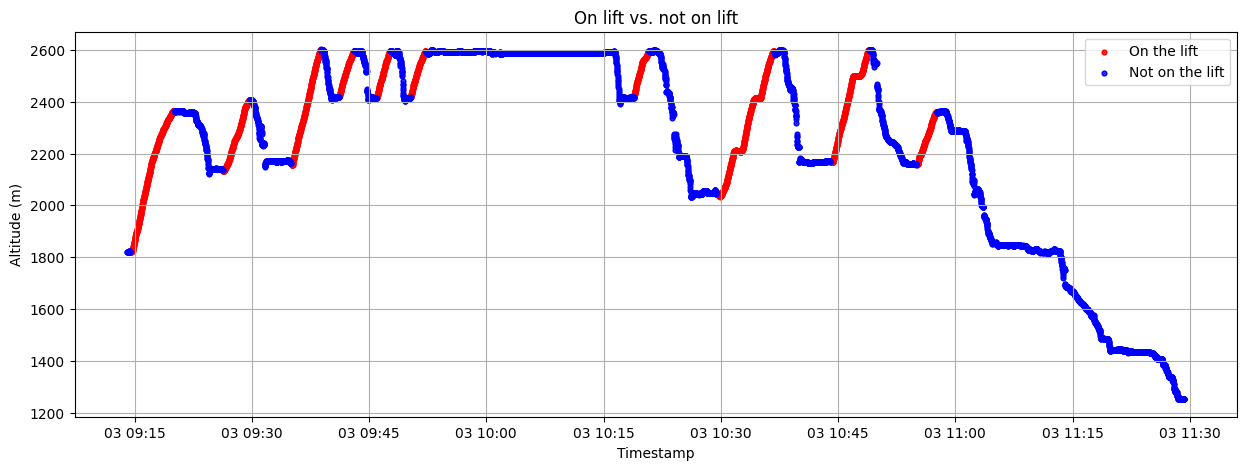

3


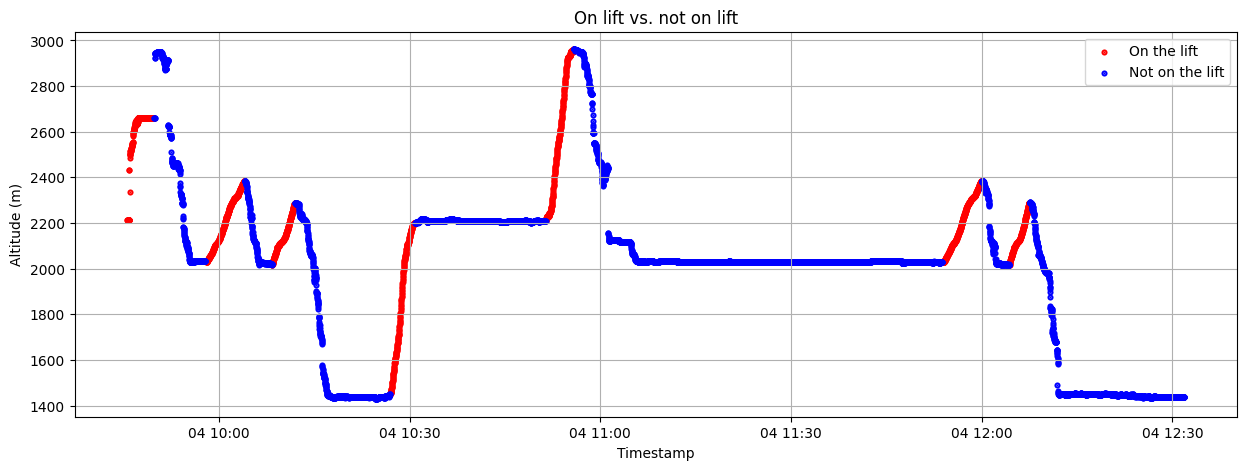

4


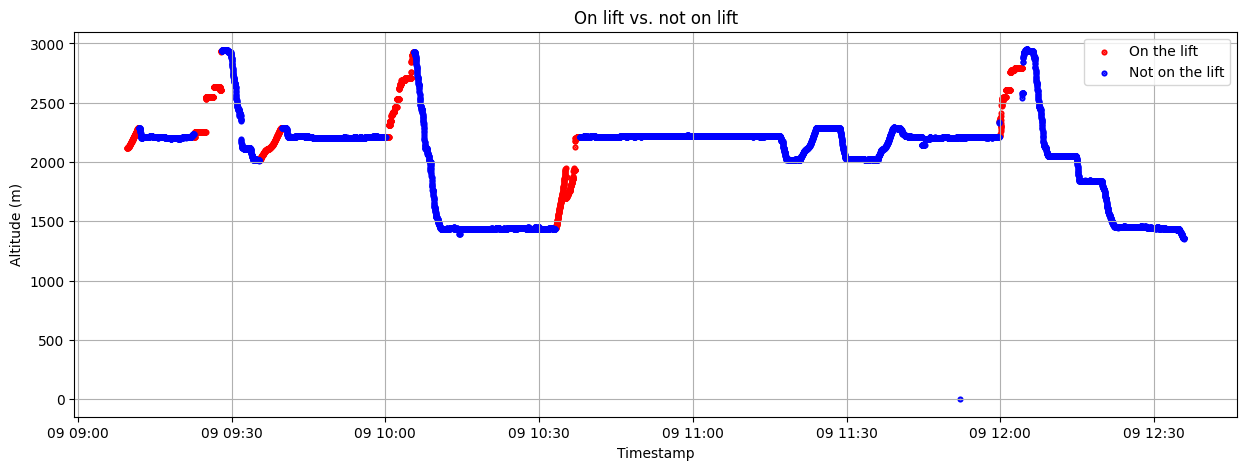

5


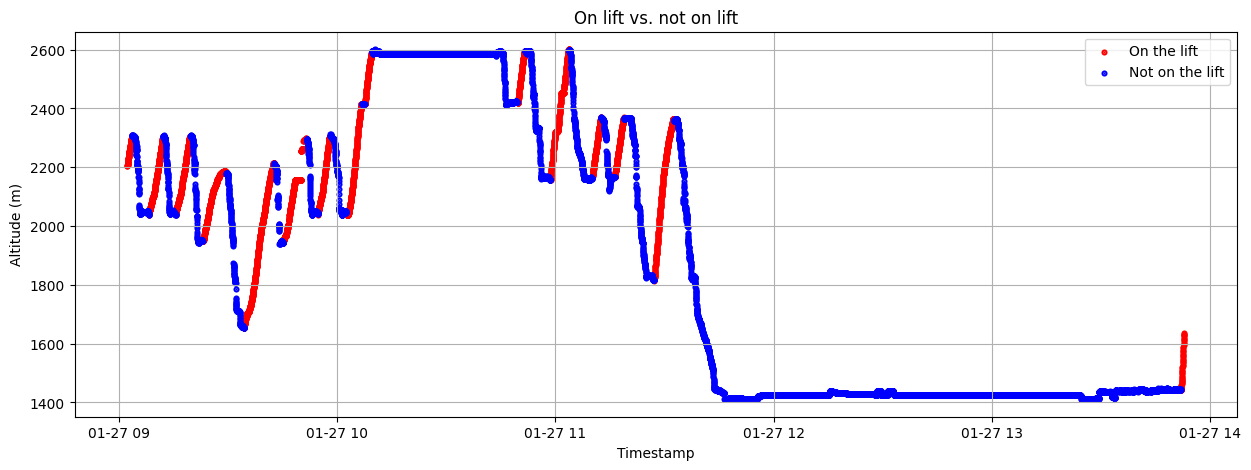

6


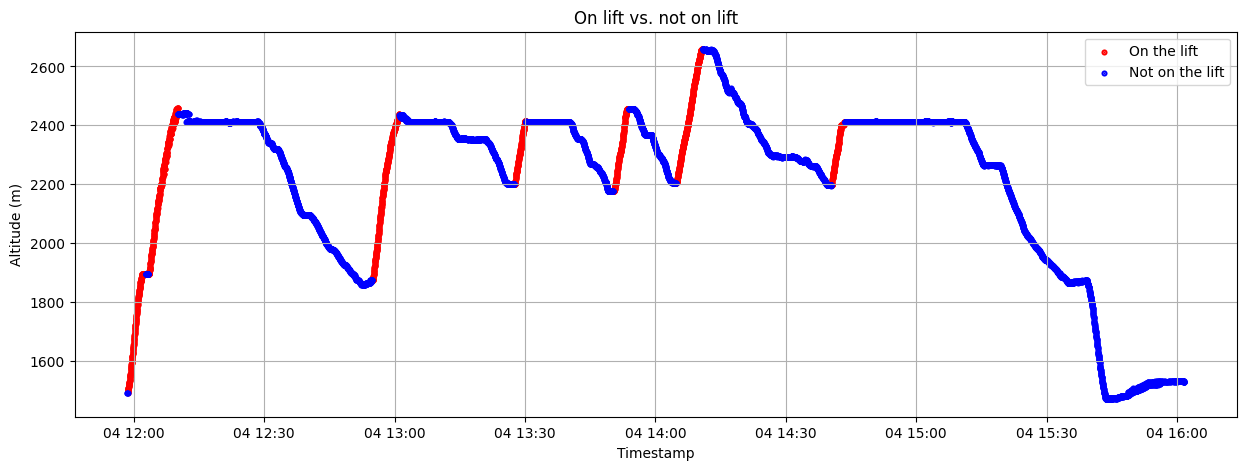

7


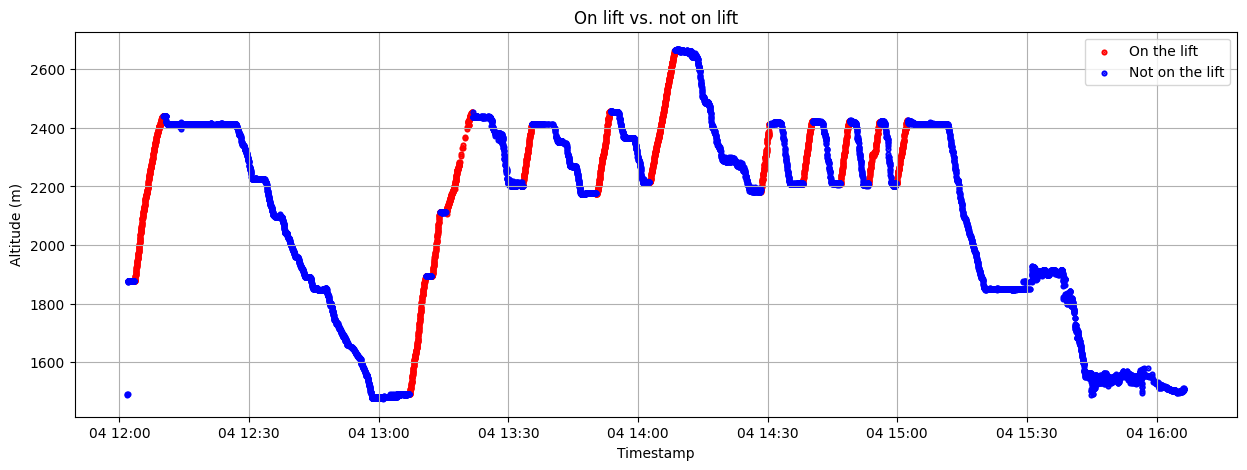

-------------- Test Files To Predict on ---------------------


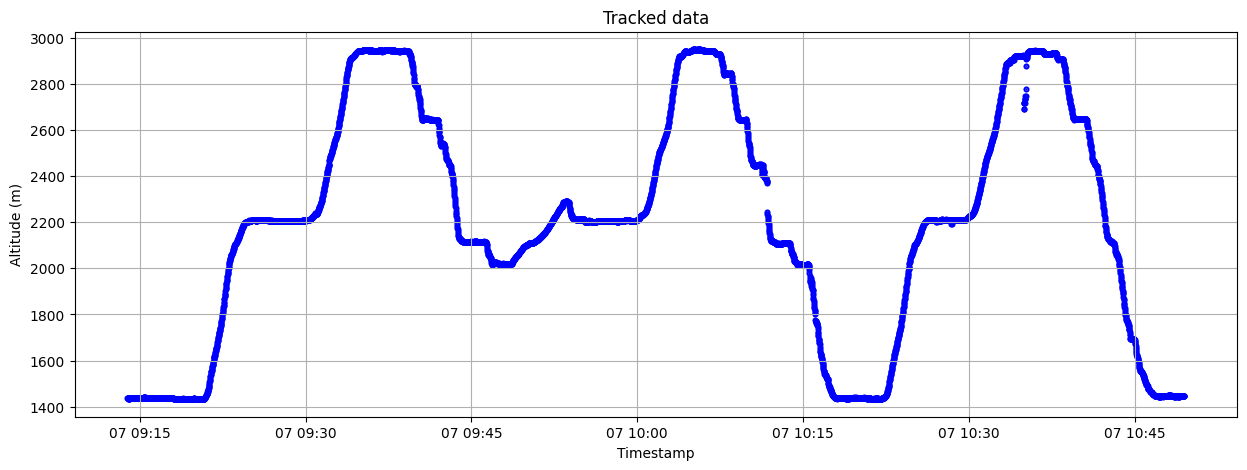

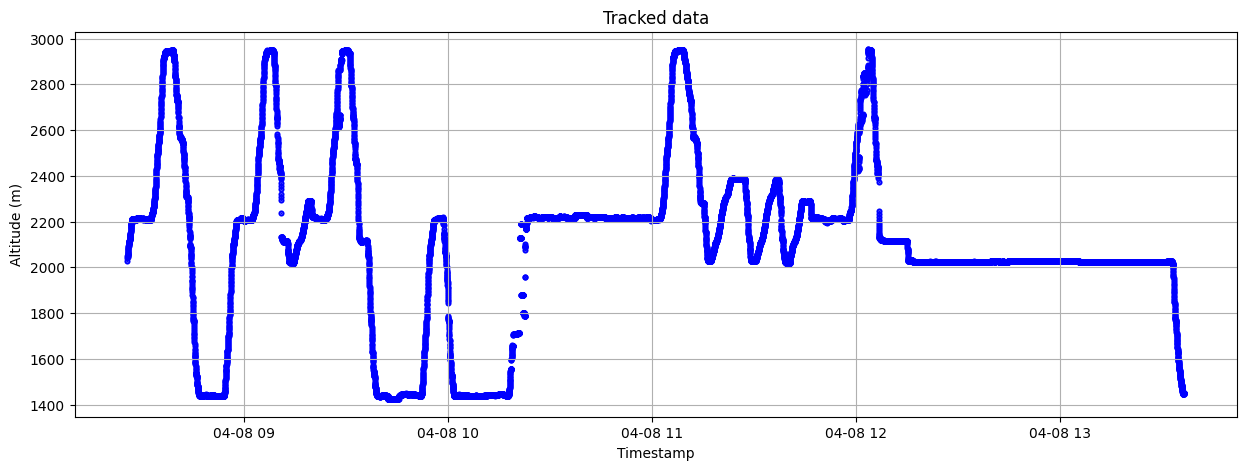

In [16]:
# Plot and double check imported csv files for correct labelling
plot_number=1
for df in df_lst_train:
    print(plot_number)
    plot_on_lift_or_not_on_lift(df)
    plot_number+=1
print('-------------- Test Files To Predict on ---------------------')
for df in df_lst_test:
    plot_lift_rides(df)

### Concatenate dfs and feature engineering with outlier removal

In [17]:
# 'ignore_index=True' resets the index of the concatenated dataframe
df_train_concatenated = pd.concat(df_lst_train, ignore_index=True)
# check result
df_train_concatenated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73793 entries, 0 to 73792
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Timestamp                 73793 non-null  datetime64[ns]
 1   accelX(g)                 73793 non-null  float64       
 2   accelY(g)                 73793 non-null  float64       
 3   accelZ(g)                 73793 non-null  float64       
 4   accelUserX(g)             73793 non-null  float64       
 5   accelUserY(g)             73793 non-null  float64       
 6   accelUserZ(g)             73793 non-null  float64       
 7   gyroX(rad/s)              73793 non-null  float64       
 8   gyroY(rad/s)              73793 non-null  float64       
 9   gyroZ(rad/s)              73793 non-null  float64       
 10  Roll(rads)                73793 non-null  float64       
 11  Pitch(rads)               73793 non-null  float64       
 12  Yaw(rads)         

In [18]:
# 'ignore_index=True' resets the index of the concatenated dataframe
df_test_concatenated = pd.concat(df_lst_test, ignore_index=True)
# check result
df_test_concatenated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24294 entries, 0 to 24293
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Timestamp                 24294 non-null  datetime64[ns]
 1   accelX(g)                 24294 non-null  float64       
 2   accelY(g)                 24294 non-null  float64       
 3   accelZ(g)                 24294 non-null  float64       
 4   accelUserX(g)             24294 non-null  float64       
 5   accelUserY(g)             24294 non-null  float64       
 6   accelUserZ(g)             24294 non-null  float64       
 7   gyroX(rad/s)              24294 non-null  float64       
 8   gyroY(rad/s)              24294 non-null  float64       
 9   gyroZ(rad/s)              24294 non-null  float64       
 10  Roll(rads)                24294 non-null  float64       
 11  Pitch(rads)               24294 non-null  float64       
 12  Yaw(rads)         

##### Altitude Change

(73793, 46)
(73521, 46)


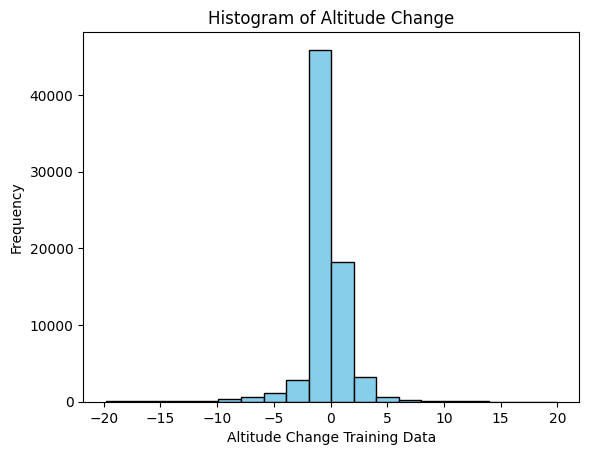

In [20]:
# Add Altitude Change for training data
df_train_concatenated['Alt(m)_change'] = df_train_concatenated['Alt(m)'].diff().fillna(0)
print(df_train_concatenated.shape)

# Set the threshold value for filtering
threshold = 20

# Filter the DataFrame based on the absolute value of 'Alt(m)_change' column
df_train_concatenated = df_train_concatenated[df_train_concatenated['Alt(m)_change'].abs() <= threshold]


# Verify
print(df_train_concatenated.shape)
altitude_change_training_data_filtered = df_train_concatenated['Alt(m)_change']

# Create a histogram plot
plt.hist(altitude_change_training_data_filtered,
         bins=20,
         color='skyblue',
         edgecolor='black')

#Add labels and title
plt.xlabel('Altitude Change Training Data')
plt.ylabel('Frequency')
plt.title('Histogram of Altitude Change')

#Show the plot
plt.show()

(24294, 47)
(24243, 47)


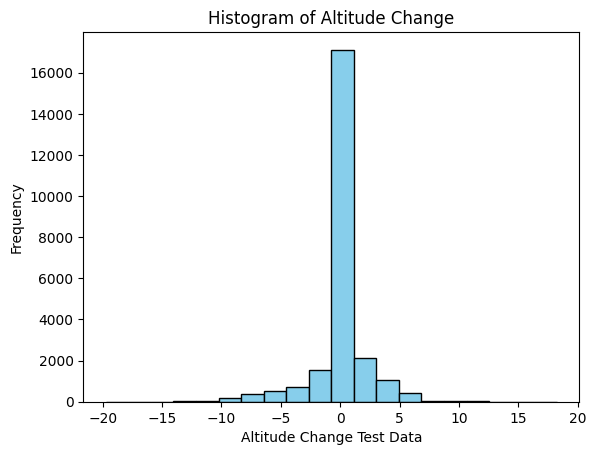

In [21]:
# Add Altitude Change for test data
df_test_concatenated['Alt(m)_change'] = df_test_concatenated['Alt(m)'].diff().fillna(0)
print(df_test_concatenated.shape)

# Set the threshold value for filtering
threshold = 20

# Filter the DataFrame based on the absolute value of 'Alt(m)_change' column
df_test_concatenated = df_test_concatenated[df_test_concatenated['Alt(m)_change'].abs() <= threshold]


# Verify
print(df_test_concatenated.shape)
altitude_change_testing_data_filtered = df_test_concatenated['Alt(m)_change']

# Create a histogram plot
plt.hist(altitude_change_testing_data_filtered,
         bins=20,
         color='skyblue',
         edgecolor='black')

#Add labels and title
plt.xlabel('Altitude Change Test Data')
plt.ylabel('Frequency')
plt.title('Histogram of Altitude Change')

#Show the plot
plt.show()

##### Speed Change

(73521, 47)
(73071, 47)


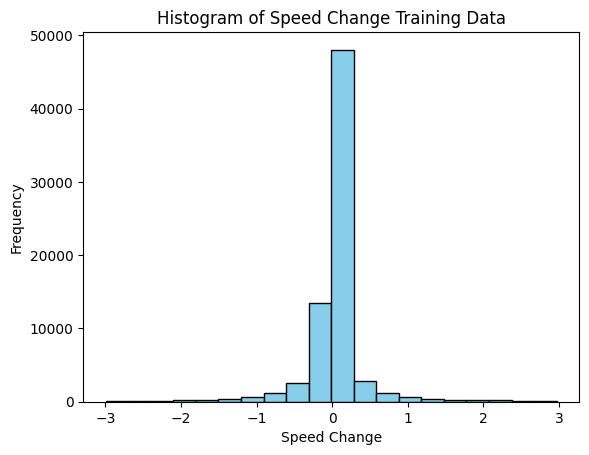

In [23]:
# Add Speed Change for training data
df_train_concatenated['Speed(m/s)_change'] = df_train_concatenated['Speed(m/s)'].diff().fillna(0)
print(df_train_concatenated.shape)

# Set the threshold value for filtering
threshold = 3

# Filter the DataFrame based on the absolute value of 'Speed(m/s)_change' column
df_train_concatenated = df_train_concatenated[df_train_concatenated['Speed(m/s)_change'].abs() <= threshold]

# Verify
print(df_train_concatenated.shape)
speed_change_training_data_filtered = df_train_concatenated['Speed(m/s)_change']

# Create a histogram plot
plt.hist(speed_change_training_data_filtered,
         bins=20,
         color='skyblue',
         edgecolor='black')

#Add labels and title
plt.xlabel('Speed Change')
plt.ylabel('Frequency')
plt.title('Histogram of Speed Change Training Data')

#Show the plot
plt.show()

(23960, 48)
(23862, 48)


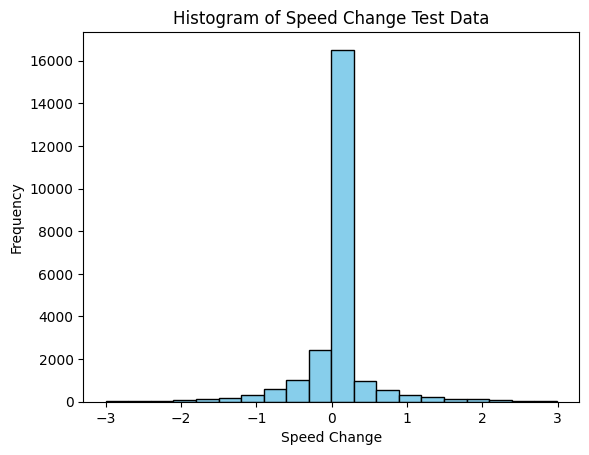

In [26]:
# Add Speed Change for testing data
df_test_concatenated['Speed(m/s)_change'] = df_test_concatenated['Speed(m/s)'].diff().fillna(0)
print(df_test_concatenated.shape)

# Set the threshold value for filtering
threshold = 3

# Filter the DataFrame based on the absolute value of 'Speed(m/s)_change' column
df_test_concatenated = df_test_concatenated[df_test_concatenated['Speed(m/s)_change'].abs() <= threshold]

# Verify
print(df_test_concatenated.shape)
speed_change_testing_data_filtered = df_test_concatenated['Speed(m/s)_change']

# Create a histogram plot
plt.hist(speed_change_testing_data_filtered,
         bins=20,
         color='skyblue',
         edgecolor='black')

#Add labels and title
plt.xlabel('Speed Change')
plt.ylabel('Frequency')
plt.title('Histogram of Speed Change Test Data')

#Show the plot
plt.show()

##### Course change

In [27]:
# Add Course Change to training data
df_train_concatenated['Course_change'] = df_train_concatenated['Course'].diff().fillna(0)
# Add Course Change to test data a
df_test_concatenated['Course_change'] = df_test_concatenated['Course'].diff().fillna(0)

In [28]:
# Verify
print(df_train_concatenated.info())
print(df_test_concatenated.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73071 entries, 0 to 73792
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Timestamp                 73071 non-null  datetime64[ns]
 1   accelX(g)                 73071 non-null  float64       
 2   accelY(g)                 73071 non-null  float64       
 3   accelZ(g)                 73071 non-null  float64       
 4   accelUserX(g)             73071 non-null  float64       
 5   accelUserY(g)             73071 non-null  float64       
 6   accelUserZ(g)             73071 non-null  float64       
 7   gyroX(rad/s)              73071 non-null  float64       
 8   gyroY(rad/s)              73071 non-null  float64       
 9   gyroZ(rad/s)              73071 non-null  float64       
 10  Roll(rads)                73071 non-null  float64       
 11  Pitch(rads)               73071 non-null  float64       
 12  Yaw(rads)         

### Feature Selection

In [29]:
# List of features
features_and_target = ['accelX(g)', 'accelY(g)', 'accelZ(g)', 'accelUserX(g)', 'accelUserY(g)',
       'accelUserZ(g)', 'gyroX(rad/s)', 'gyroY(rad/s)', 'gyroZ(rad/s)',
       'Roll(rads)', 'Pitch(rads)', 'Yaw(rads)', 'Lat', 'Long', 'Speed(m/s)',
       'HorizontalAccuracy(m)', 'VerticalAccuracy(m)', 'Course', 'calMagX(µT)',
       'calMagY(µT)', 'calMagZ(µT)', 'on_lift', 'Alt(m)_change',
       'Speed(m/s)_change', 'Course_change']



# Drop the specified features from the train DataFrame
df_train_cleaned = df_train_concatenated[features_and_target]

# Drop the specified features from the test DataFrame
df_test_cleaned = df_test_concatenated[features_and_target]

# Verify
df_train_cleaned.info()
print('-----------------------------')
df_test_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73071 entries, 0 to 73792
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   accelX(g)              73071 non-null  float64
 1   accelY(g)              73071 non-null  float64
 2   accelZ(g)              73071 non-null  float64
 3   accelUserX(g)          73071 non-null  float64
 4   accelUserY(g)          73071 non-null  float64
 5   accelUserZ(g)          73071 non-null  float64
 6   gyroX(rad/s)           73071 non-null  float64
 7   gyroY(rad/s)           73071 non-null  float64
 8   gyroZ(rad/s)           73071 non-null  float64
 9   Roll(rads)             73071 non-null  float64
 10  Pitch(rads)            73071 non-null  float64
 11  Yaw(rads)              73071 non-null  float64
 12  Lat                    73071 non-null  float64
 13  Long                   73071 non-null  float64
 14  Speed(m/s)             73071 non-null  float64
 15  Ho

### Modelling

In [30]:
# Split the dataset into features and target variable
X = df_train_cleaned.drop('on_lift', axis=1)
y = df_train_cleaned['on_lift']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# Verify the shape of the features (X) and target (y) variables
print("X shape:", X.shape)
print("y shape:", y.shape)

print('-----------------------------')

# Verify the shape of the training and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X shape: (73071, 24)
y shape: (73071,)
-----------------------------
X_train shape: (58456, 24)
X_test shape: (14615, 24)
y_train shape: (58456,)
y_test shape: (14615,)


In [31]:
# Initialise Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100,
                            max_depth=10,
                            min_samples_split=2,
                            min_samples_leaf=1,
                            max_features='auto',
                            random_state=42)

In [32]:
# Train the model
rf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_depth=10, max_features='auto', random_state=42)

### Model evaluation

In [33]:
# Training data

predictions = rf.predict(X_test)
true_labels = y_test

# Evaluate accuracy
accuracy = accuracy_score(true_labels, predictions)
print("Accuracy:", accuracy)

# Get classification report for precision, recall, F1-score
print("Classification Report:")
print(classification_report(true_labels, predictions))

Accuracy: 0.9842627437564146
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11806
           1       0.98      0.93      0.96      2809

    accuracy                           0.98     14615
   macro avg       0.98      0.96      0.97     14615
weighted avg       0.98      0.98      0.98     14615



In [34]:
# Evaluation on test data

X_eval=df_test_cleaned.drop('on_lift', axis=1)
y_eval=df_test_cleaned['on_lift']

predictions = rf.predict(X_eval)
true_labels = y_eval

# Evaluate accuracy
accuracy = accuracy_score(true_labels, predictions)
print("Accuracy:", accuracy)

# Get classification report for precision, recall, F1-score
print("Classification Report:")
print(classification_report(true_labels, predictions))

Accuracy: 0.9409521414801777
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     18980
           1       0.99      0.72      0.83      4882

    accuracy                           0.94     23862
   macro avg       0.96      0.86      0.90     23862
weighted avg       0.94      0.94      0.94     23862



### Plot predictions

In [35]:
df_test_concatenated['predicted']=predictions
df_test_concatenated['Timestamp'] = pd.to_datetime(df_test_concatenated['Timestamp'], unit='ns')

df_test_concatenated.info()
df_test_concatenated

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23862 entries, 0 to 24293
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Timestamp                 23862 non-null  datetime64[ns]
 1   accelX(g)                 23862 non-null  float64       
 2   accelY(g)                 23862 non-null  float64       
 3   accelZ(g)                 23862 non-null  float64       
 4   accelUserX(g)             23862 non-null  float64       
 5   accelUserY(g)             23862 non-null  float64       
 6   accelUserZ(g)             23862 non-null  float64       
 7   gyroX(rad/s)              23862 non-null  float64       
 8   gyroY(rad/s)              23862 non-null  float64       
 9   gyroZ(rad/s)              23862 non-null  float64       
 10  Roll(rads)                23862 non-null  float64       
 11  Pitch(rads)               23862 non-null  float64       
 12  Yaw(rads)         

,Timestamp,accelX(g),accelY(g),accelZ(g),accelUserX(g),accelUserY(g),accelUserZ(g),gyroX(rad/s),gyroY(rad/s),gyroZ(rad/s),...,magZ(µT),calMagX(µT),calMagY(µT),calMagZ(µT),Cluster_1,on_lift,Alt(m)_change,Speed(m/s)_change,Course_change,predicted
0,2023-04-07 09:13:51.953,0.1534,-0.5180,-0.8395,-0.0108,0.0025,-0.0101,0.0166,0.0051,0.0318,...,-65.9999,-27.1108,6.9614,-7.9447,0,0,0.000000,0.0000,0.0,0
1,2023-04-07 09:13:52.957,0.1562,-0.5118,-0.8333,-0.0094,0.0023,0.0054,0.0042,0.0032,-0.0066,...,-66.4066,-26.8162,7.0748,-8.5435,0,0,0.425781,0.2534,0.0,0
2,2023-04-07 09:13:53.961,0.1508,-0.5035,-0.8493,-0.0059,0.0053,-0.0014,0.0020,0.0021,0.0225,...,-67.0690,-27.0917,7.1687,-9.2339,0,0,0.415528,-0.2209,0.0,0
3,2023-04-07 09:13:54.965,0.1604,-0.5134,-0.8229,-0.0070,0.0025,0.0136,0.0594,0.0147,0.0097,...,-66.2895,-26.4431,7.0141,-7.9350,0,0,-0.067871,0.3034,0.0,0
4,2023-04-07 09:13:55.969,0.1569,-0.5341,-0.8330,0.0065,-0.0080,0.0061,-0.0024,0.0176,0.0147,...,-66.0967,-28.3148,7.0149,-8.3881,0,0,0.000000,-0.5294,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24289,2023-04-08 13:36:22.887,-0.1306,-0.4372,-1.0096,-0.1329,-0.0651,-0.0815,0.6196,0.5358,-0.1787,...,-83.9174,-12.1714,-35.7323,-31.8777,1,0,-0.103271,0.0000,0.0,0
24290,2023-04-08 13:36:23.890,0.0719,-0.4624,-0.8884,-0.0267,0.0056,-0.0102,0.0011,-0.0850,-0.5501,...,-79.2239,-6.8547,-40.1080,-27.4827,1,0,-0.590820,0.0000,0.0,0
24291,2023-04-08 13:36:24.895,-0.1669,-0.7570,-0.5373,-0.3806,-0.2018,0.2665,5.2579,-2.0120,0.9900,...,-72.0463,2.9559,-43.3942,-19.9750,6,0,-0.210572,0.0000,0.0,0
24292,2023-04-08 13:36:25.898,0.2455,-0.1281,-1.1840,0.1035,-0.0669,-0.1960,-0.0707,-0.5946,-0.3314,...,-92.9536,-3.0172,-24.6688,-41.0723,1,0,0.214478,0.0000,0.0,0


In [36]:
# plot predictions
check_predictions(df_test_concatenated)

In [37]:
# Perform permutation importance
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

In [38]:
perm_importance

{'importances_mean': array([ 1.45740677e-03,  1.77215190e-03,  1.29387615e-02,  1.09476565e-04,
         2.18953130e-04,  1.64214848e-04, -1.11022302e-17,  2.73691413e-04,
         2.39479986e-04,  6.34279849e-03,  2.86007527e-03,  2.01163189e-03,
         1.63735888e-02,  1.59425248e-02,  7.86520698e-02,  8.24495381e-03,
         3.09271297e-03,  7.18439959e-03,  6.30858707e-03,  5.00171057e-03,
         3.85904892e-03,  3.24187479e-02,  3.28429696e-04,  1.06055423e-03]),
 'importances_std': array([0.00020538, 0.00012411, 0.00069472, 0.00016816, 0.00015543,
        0.00015053, 0.00010149, 0.00020978, 0.00012709, 0.00027378,
        0.00028012, 0.00015959, 0.0004002 , 0.000636  , 0.00182273,
        0.00031541, 0.00030261, 0.0004953 , 0.00031025, 0.00034949,
        0.0002294 , 0.00105815, 0.00013956, 0.00024527]),
 'importances': array([[ 1.30003421e-03,  1.84741704e-03,  1.30003421e-03,
          1.57372562e-03,  1.50530277e-03,  1.57372562e-03,
          1.50530277e-03,  1.02634280e

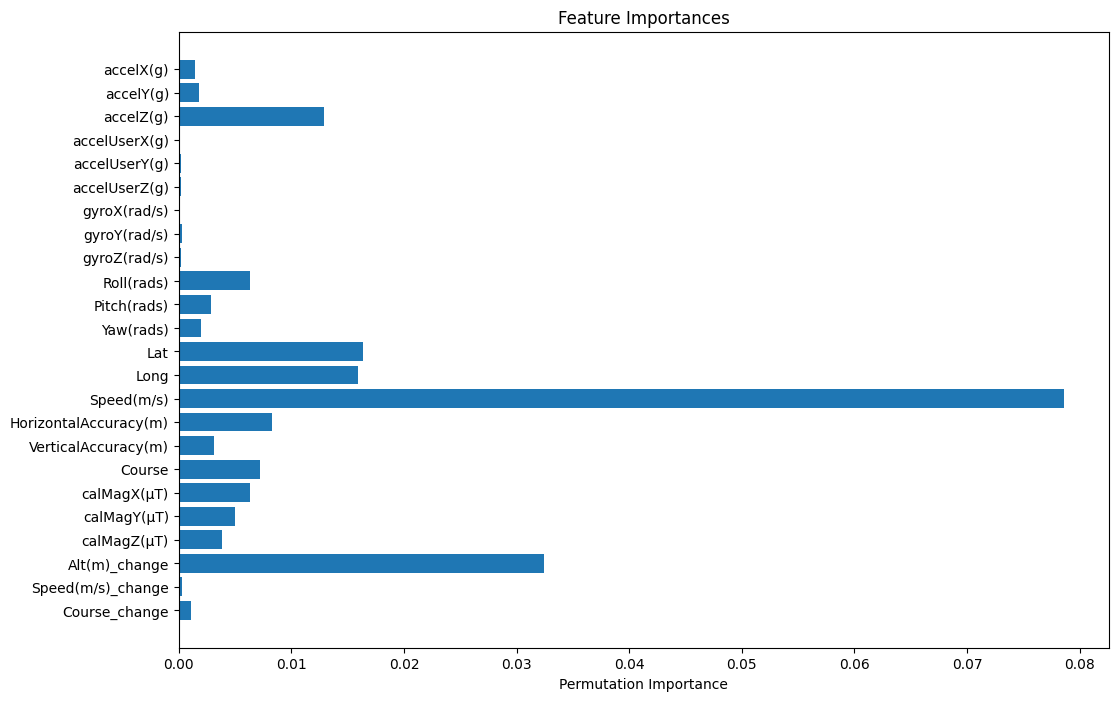

In [39]:
# Get the feature names
feature_names = X.columns

# Get the mean importances
importances_mean = perm_importance['importances_mean']

# Create a bar chart
plt.figure(figsize=(12, 8))
plt.barh(feature_names, importances_mean)
plt.xlabel('Permutation Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert the y-axis to show the most important features at the top
plt.show()


### Model Export

In [40]:
# # Export the trained model
joblib.dump(rf,
             'rf_v_0.4.1.pkl')

['rf_v_0.4.1.pkl']